In [1]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from collections import OrderedDict

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
dataset_location = '/home/marcin/Datasets/udacity-challange-flower-data/flower_data/'

In [4]:
transformations = transforms.Compose([
    transforms.Resize(256),
    transforms.Pad(100, padding_mode='reflect'),
    transforms.RandomRotation(45),
    transforms.CenterCrop(256),
    transforms.RandomResizedCrop(224, scale=(0.8 , 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], 
                         [0.229, 0.224, 0.225])
])
transformations = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], 
                         [0.229, 0.224, 0.225])
])

In [5]:
dataset_train_augmented = datasets.ImageFolder(os.path.join(dataset_location, 'train'), transforms_augmented)
dataset_train_normal = datasets.ImageFolder(os.path.join(dataset_location, 'train'), transforms_normal)
dataset_valid_normal = datasets.ImageFolder(os.path.join(dataset_location, 'valid'), transforms_normal)
print('Number of train images:', len(dataset_train_normal))
print('Number of validation images:', len(dataset_valid_normal))

Number of train images: 6552
Number of validation images: 818


In [6]:
dataloader_train_augmented = torch.utils.data.DataLoader(dataset_train_augmented, batch_size=16, shuffle=False,
                                                     num_workers=6, pin_memory=True)
dataloader_train_normal = torch.utils.data.DataLoader(dataset_train_normal, batch_size=16, shuffle=False,
                                                     num_workers=6, pin_memory=True)
dataloader_valid_normal = torch.utils.data.DataLoader(dataset_valid_normal, batch_size=16, shuffle=True,
                                                     num_workers=6, pin_memory=True)

**Test Augumentations**

In [7]:
images, labels = iter(dataloader_train_normal).next()

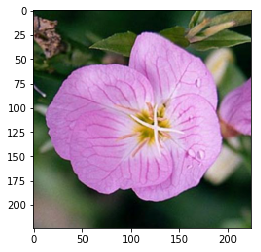

In [8]:
def show_tensor(ax, img_tensor):
    ttt = np.array(img_tensor.permute(2, 1, 0))
    ttt = ttt * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]  # undo normalization
    ax.imshow( np.array(ttt*255, dtype=int) )

fig, ax = plt.subplots()    
show_tensor(ax, images[0])

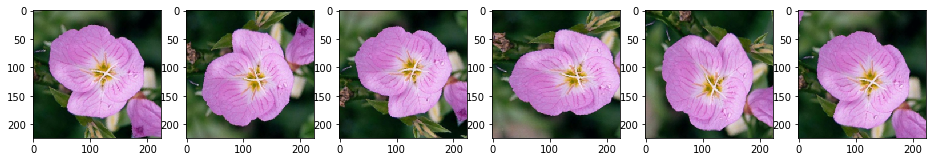

In [9]:
fig, axes = plt.subplots(ncols=6, figsize=[16,6])
for ax in axes:
    images, labels = iter(dataloader_train_augmented).next()
    show_tensor(ax, images[0])

# Precompute Features

In [10]:
class Passthrough(torch.nn.Module):
    def forward(self, input):
        return input

In [11]:
#model_cnn = models.densenet121(pretrained=True)
model_cnn = models.resnet50(pretrained=True)
#model_cnn = models.resnet152(pretrained=True)
#model_cnn = models.inception_v3(pretrained=True)
#model_cnn = models.densenet201(pretrained=True)

# disable all gradients
for param in model_cnn.parameters():
    param.requires_grad = False

model_cnn.classifier = Passthrough()
model_cnn.to(device);

In [12]:
def extract_features(model_cnn, dataloader):
    """
    Params:
        model_cnn - big convnet with final dense layers removed
        dataloader - we get data from here
    """
    features_list = []
    labels_list = []
    
    model_cnn.eval()
    for images, labels in dataloader:
        images = images.to(device)
        outputs = model_cnn(images)
        features_list.append(outputs.cpu().numpy())
        labels_list.append(labels.numpy())

    features_arr = np.concatenate(features_list)
    labels_arr = np.concatenate(labels_list)

    return features_arr, labels_arr

In [13]:
train_features_normal, train_labels_normal = extract_features(model_cnn, dataloader_train_normal)

In [14]:
print('Shape of train features (inputs):', train_features_normal.shape)
print('Shape of train labels (targets): ', train_labels_normal.shape)
print('Type of train feat. and labels:  ', train_features_normal.dtype, train_labels_normal.dtype)
print('Sample of labels:', train_labels_normal[:20])

Shape of train features (inputs): (6552, 1000)
Shape of train labels (targets):  (6552,)
Type of train feat. and labels:   float32 int64
Sample of labels: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [15]:
valid_features_normal, valid_labels_normal = extract_features(model_cnn, dataloader_valid_normal)

In [16]:
print('Shape of validation features (inputs):', valid_features_normal.shape)
print('Shape of validation labels (targets): ', valid_labels_normal.shape)
print('Type of valid. features and labels:   ', valid_features_normal.dtype, valid_labels_normal.dtype)
print('Sample of labels:', valid_labels_normal[:20])

Shape of validation features (inputs): (818, 1000)
Shape of validation labels (targets):  (818,)
Type of valid. features and labels:    float32 int64
Sample of labels: [ 79   9  53  41  17   2  97  43  56  96 101  99  97  36  59  85 101  94
  72  47]


In [17]:
train_features_augmented = []
train_labels_augmented = []

for e in range(3):
    tmp_feat, tmp_labels = extract_features(model_cnn, dataloader_train_augmented)
    train_features_augmented.append(tmp_feat)
    train_labels_augmented.append(tmp_labels)
    
train_features_augmented = np.array(train_features_augmented)
train_labels_augmented = np.array(train_labels_augmented)

In [18]:
print('Shape of train features (inputs):', train_features_augmented.shape)
print('Shape of train labels (targets): ', train_labels_augmented.shape)
print('Type of train feat. and labels:  ', train_features_augmented.dtype, train_labels_augmented.dtype)
print('Sample of labels:', train_labels_augmented[:20])

Shape of train features (inputs): (3, 6552, 1000)
Shape of train labels (targets):  (3, 6552)
Type of train feat. and labels:   float32 int64
Sample of labels: [[  0   0   0 ... 101 101 101]
 [  0   0   0 ... 101 101 101]
 [  0   0   0 ... 101 101 101]]


In [59]:
x_train = torch.tensor(train_features_normal).to(device)
y_train = torch.tensor(train_labels_normal).to(device)
x_valid = torch.tensor(valid_features_normal).to(device)
y_valid = torch.tensor(valid_labels_normal).to(device)

# Train Model

In [60]:
def accuracy(logits, labels): 
    predictions = torch.argmax(logits, dim=1)
    return (predictions == labels).float().mean()  # tensor!!

In [61]:
model = nn.Sequential(OrderedDict([
    ('fc1', nn.Linear(1920, 512)),
    ('relu', nn.ReLU()),
    ('dropout', nn.Dropout(0.2)),
    ('fc2', nn.Linear(512, 102)),
]))
model.to(device)

criterion = nn.CrossEntropyLoss() # nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters()) #, lr=0.001)

hist = { 'tepoch':[], 'tloss':[], 'tacc':[],    # mini-batch loss/acc every iteration
         'train_loss':[], 'train_acc':[],       # train set loss/acc every epoch
         'valid_loss':[], 'valid_acc':[] }      # valid set loss/acc every epoch

In [62]:
num_epochs = 30
batch_size = 16

for epoch in range(num_epochs):
    
    ### Train ###
    model.train()
    indices = torch.randperm(len(x_train), device=device)          # indices = [2423, 1563, 4854, ...]
    for i in range(0, len(x_train), batch_size):                   # i = 0, batch_size, 2*batch_size, ...
        
        # Pick mini-batch
        x = x_train[indices[i:i+batch_size]]
        y = y_train[indices[i:i+batch_size]]
        
        # Optimize
        optimizer.zero_grad()
        outputs = model(x)                                         # logits
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
        
        # Record per-iteration stats
        with torch.no_grad():
            acc = accuracy(outputs, y)
            hist['tepoch'].append( epoch )
            hist['tacc'].append( acc.item() )
            hist['tloss'].append( loss.item() )
            
    ### Evaluate ###
    model.eval()
    with torch.no_grad():
        
        # Eval on train set
        outputs = model(x_train)                                   # pass-in whole train dataset at once
        loss = criterion(outputs, y_train)
        acc = accuracy(outputs, y_train)
        hist['train_acc'].append( acc.item() )
        hist['train_loss'].append( loss.item() )
        
        # Eval on valid set
        outputs = model(x_valid)
        loss = criterion(outputs, y_valid)
        acc = accuracy(outputs, y_valid)
        hist['valid_acc'].append( acc.item() )
        hist['valid_loss'].append( loss.item() )
    
    ### Print Summary ###
    print(f'Epoch: {epoch:3}'
          f'    Train loss/acc: {loss:6.4f} / {acc:6.4f}'
          f'    Valid: {loss:6.4f} / {acc:6.4f}')

Epoch:   0    Train loss/acc: 0.6378 / 0.8778    Valid: 0.6378 / 0.8778
Epoch:   1    Train loss/acc: 0.3885 / 0.9059    Valid: 0.3885 / 0.9059
Epoch:   2    Train loss/acc: 0.3438 / 0.9181    Valid: 0.3438 / 0.9181
Epoch:   3    Train loss/acc: 0.3293 / 0.9193    Valid: 0.3293 / 0.9193
Epoch:   4    Train loss/acc: 0.2707 / 0.9291    Valid: 0.2707 / 0.9291
Epoch:   5    Train loss/acc: 0.2478 / 0.9279    Valid: 0.2478 / 0.9279
Epoch:   6    Train loss/acc: 0.2262 / 0.9328    Valid: 0.2262 / 0.9328
Epoch:   7    Train loss/acc: 0.2247 / 0.9377    Valid: 0.2247 / 0.9377
Epoch:   8    Train loss/acc: 0.2534 / 0.9364    Valid: 0.2534 / 0.9364
Epoch:   9    Train loss/acc: 0.2544 / 0.9401    Valid: 0.2544 / 0.9401
Epoch:  10    Train loss/acc: 0.2836 / 0.9205    Valid: 0.2836 / 0.9205
Epoch:  11    Train loss/acc: 0.3077 / 0.9267    Valid: 0.3077 / 0.9267
Epoch:  12    Train loss/acc: 0.3438 / 0.9279    Valid: 0.3438 / 0.9279
Epoch:  13    Train loss/acc: 0.2642 / 0.9340    Valid: 0.2642 /

In [49]:
def pretty_plot(ax, data, label, color, alpha):
    def smooth(y, n):
        return np.convolve(y, v=np.ones(n)/n, mode='same')
    #ax.scatter(range(len(data)), data, marker='.', s=1, color=color, alpha=alpha/5)
    ax.plot(smooth(data, 55), label=label, color=color, alpha=alpha)

In [50]:
def plot_hist(hist, title):
    fig, (ax, ax2) = plt.subplots(nrows=1, ncols=2, figsize=[16,3])
     
    fig.suptitle(title, fontsize=16)
    
    #ax.plot(hist['train_loss'], label='train_loss', color='blue')
    pretty_plot(ax.twiny(), hist['tloss'], 'tloss', color='blue', alpha=.5)
    ax.plot(hist['valid_loss'], label='valid_loss', color='orange')
    ax.set_title('Loss'); ax.legend(); ax.grid(); ax.set_ylim([0, 1]);
    
    #fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[16,3])
    ax2.plot(hist['train_acc'], label='train_acc', color='blue')
    #pretty_plot(ax2.twiny(), hist['tacc'], 'tacc', color='blue', alpha=1)
    ax2.plot(hist['valid_acc'], label='valid_acc', color='orange')
    ax2.set_title('Accuracy'); ax2.legend(); ax2.grid(); ax2.set_ylim([.8, 1]);
    
    plt.tight_layout()

# Results

Param in_features was set to match CNN output size.

In [26]:
print(model)

Sequential(
  (fc1): Linear(in_features=1000, out_features=512, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2)
  (fc2): Linear(in_features=512, out_features=102, bias=True)
)


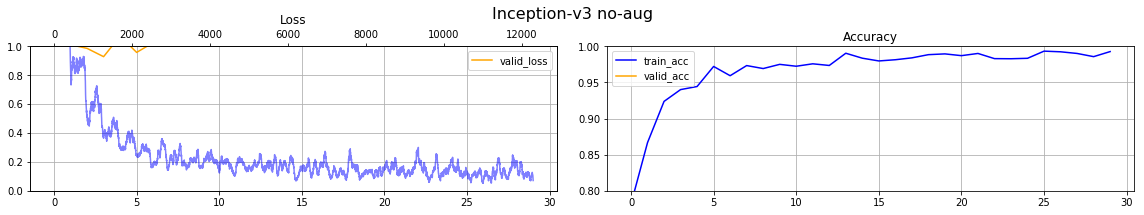

In [51]:
plot_hist(hist, title='Inception-v3 no-aug')

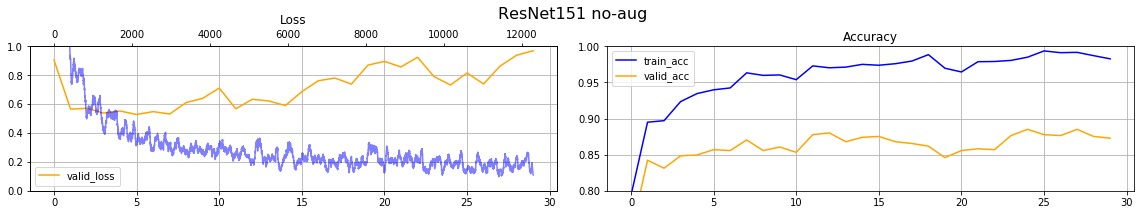

In [38]:
plot_hist(hist, title='ResNet151 no-aug')

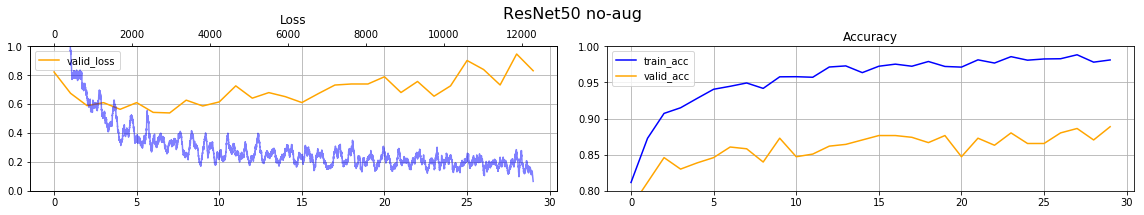

In [27]:
plot_hist(hist, title='ResNet50 no-aug')

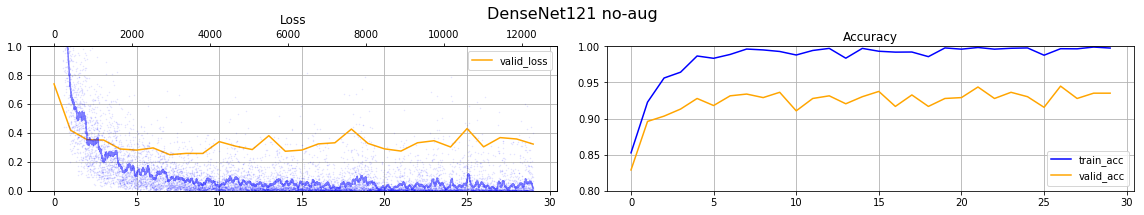

In [167]:
plot_hist(hist, title='DenseNet121 no-aug')

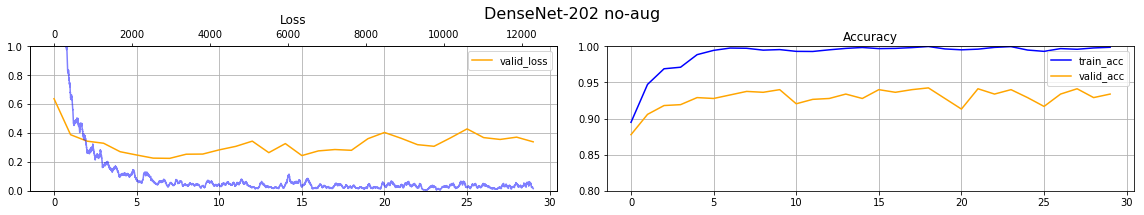

In [64]:
plot_hist(hist, title='DenseNet-202 no-aug')